# 知能機械情報学 レポート課題 1 (課題A選択)

締切: 7月30日10時(AM).提出先:工2号館3F機械系事務室.

下記の課題(AまたはBを選択)について,学籍番号,氏名、概要説明,前提条件やパラ
メータ,関連事項の調査結果や独自の工夫,実験・解析結果,考察,参考文献リス
ト,講義の感想をレポートにまとめ,紙面で上記に提出せよ.  
また,作成したプログラム,データファイル,レポート文書のPDF等を,Subject:Hopfield
として,メール本文に学籍番号と氏名を明記してLec-IMI@isi.imi.i.u-tokyo.ac.jpに
添付ファイルとして送付せよ.無断転載等が確認されたものは履修成績を不合格と
することがある.引用を忘れずに.他者と協力した場合はその番号・氏名を明記.  

**課題A:Hopfield型のニューラルネットをシミュレートするプログラムを作り,まず1種類の
5x5の2値(+1/-1)画像を覚えさせ,元画像にノイズ(5~20%の一通り)を加えた画像
を初期値として想起する実験をせよ.同条件で画像の種類を6程度まで徐々に増や
して想起性能を調べよ.また,画像が2種類と4種類の場合について,ノイズを0%
から100%(50%以上の意味は何か?)まで徐々に増やして想起性能を調べよ.そ
の他,自分なりの疑問を立てて実験的に調べよ.なお,想起性能としては,正解と
の類似度の全試行平均と,正答率(元画像を完全再現した頻度割合)を用いる.
入力画像はプログラム中でデータ配列として静的に宣言してよい.結果はグラフ等
で分かり易く示せ.上記に規定しない事項については自分で定め,説明せよ.**  

課題B:知的な情報処理の具体的な例題を3通り選定し,各々について,ニューラルネット
ワークで扱う際の方法(データの表現やネットワークモデル,計算法等)と,それ以
外の手法で扱う方法を述べ,両者の長所短所を詳細かつ具体的に比較せよ.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import random

random.seed(1)

## 5x5の2値(+1/-1)画像を作成

In [2]:
pattern1 = np.array([[-1, 1, 1, -1, -1], [-1, -1, 1, -1, -1], [-1, -1, 1, -1, -1], [-1, -1, 1, -1, -1], [-1, 1, 1, 1, -1]])
pattern2 = np.array([[-1, 1, 1, 1, -1], [-1, -1, -1, 1, -1], [-1, 1, 1, 1, -1], [-1, 1, -1, -1, -1], [-1, 1, 1, 1, -1]])
pattern3 = np.array([[-1, 1, 1, 1, -1], [-1, -1, -1, 1, -1], [-1, 1, 1, 1, -1], [-1, -1, -1, 1, -1], [-1, 1, 1, 1, -1]])
pattern4 = np.array([[-1, 1, -1, 1, -1], [-1, 1, -1, 1, -1], [-1, 1, 1, 1, -1], [-1, -1, -1, 1, -1], [-1, -1, -1, 1, -1]])
pattern5 = np.array([[-1, 1, 1, 1, -1], [-1, 1, -1, -1, -1], [-1, 1, 1, 1, -1], [-1, -1, -1, 1, -1], [-1, 1, 1, 1, -1]])
pattern6 = np.array([[-1, 1, 1, 1, -1], [-1, 1, -1, -1, -1], [-1, 1, 1, 1, -1], [-1, 1, -1, 1, -1], [-1, 1, 1, 1, -1]])

patterns = [pattern1, pattern2, pattern3, pattern4, pattern5, pattern6]

In [3]:
def show_img(pattern):
    """ patternのarrayを渡すと白黒imageを出力する関数 """
    pattern = pattern + 1
    plt.imshow(pattern, cmap='Greys')
    plt.show();

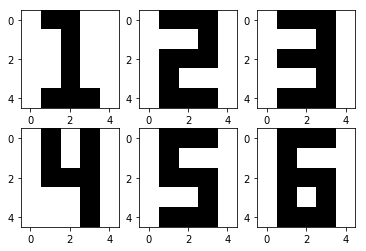

In [4]:
fig = plt.figure()
for idx, pattern in enumerate(patterns):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.imshow(pattern+1, cmap='Greys')

## Hopfield Networkの構築

In [5]:
class Hopfield():
    """ Class for Hopfield Network.
    
        Parameters
        ----------
            width : int, default 5
                画像の幅
            height : int, default 5
                画像の高さ

        Methods
        ----------
        memoralize(patterns)
            画像を暗記する
        associate(input_pattern, num_episode=100, threshold=0)
            入力画像から想起する
        reset()
            modelを初期化する
    """
    def __init__(self, width=5, height=5):
        self.width = width
        self.height = height
        self.num_pixel = height * width
        self.W = np.zeros(shape=(self.num_pixel, self.num_pixel))
        
    def memoralize(self, patterns):
        for pattern in patterns:
            # flatten
            if pattern.ndim == 2:
                pattern = pattern.reshape(1, -1).T
            # 更新
            self.W = self.W + np.dot(pattern, pattern.T)
            #対角成分は全て0 (制約)
            self.W[np.eye(self.num_pixel, dtype=bool)] = 0
            
        self.W = self.W / len(patterns)
        
    def associate(self, input_pattern, iter_num=10, threshold=0):
        # flatten
        if input_pattern.ndim == 2:
            input_pattern = input_pattern.reshape(1, -1).T
        
        # 想起する
        for _ in range(iter_num):
            input_pattern = np.dot(self.W, input_pattern)
            input_pattern = input_pattern - threshold
            input_pattern = np.sign(input_pattern)
            
        # reshapeして2次元にする
        input_pattern = input_pattern.reshape(self.height, self.width)
        
        return input_pattern
    
    def reset(self):
        self.W = np.zeros(shape=(self.num_pixel, self.num_pixel))

## 必要な関数の定義

In [6]:
def gen_noise(pattern, per=0.05):
    """ pattern画像にnoiseを加える関数
        
        Parameters
        ----------
            pattern : array_like
                画像の2次元行列
            per : float
                ノイズのパーセンテージ
        Returns
        ----------
            noise_pattern : array
                ノイズを付加した2次元行列
    """
    
    # patternの情報を取得
    height, width = pattern.shape
    num_pixel = height * width
    num_noise_pixel = int(num_pixel*per)
    noise_pattern = pattern.copy()
    
    # noiseを付加
    for _ in range(num_noise_pixel):
        x = random.randint(0, height-1)
        y = random.randint(0, width-1)
        # noiseは画素値の反転として捉える
        noise_pattern[x][y] = pattern[x][y] * (-1)
    
    return noise_pattern 

In [7]:
def isCorrect(pattern_1, pattern_2):
    """ ２つのpatternが完全一致するか否かを返す関数
    
    Parameters
    ----------
        pattern_1 : array_like
        pattern_2 : array_like
    Retunrs
    ----------
        isCorrect : bool
    """
    diff = (pattern_1 != pattern_2).sum()
    isCorrect = (diff==0)
    return isCorrect

In [8]:
def similarity(pattern_1, pattern_2):
    """ 2つのpatternの類似度(2乗距離)を返す関数
    
    Parameters
    ----------
        pattern_1 : array_like
        pattern_2 : array_like
    Returns
    ----------
        similarity : float
    """
    similarity = np.linalg.norm(pattern_1 - pattern_2, ord=2)
    return similarity

In [9]:
def ex1(model, pattern, noise_per_range=(5, 21), graph=True, debug=False):
    """ 記憶済みmodelにノイズを付加したパターン1つを入力して想起性能を調べる関数
    
    Parameters
    ----------
        model : Hopfield Class
        noise_per_range : tuple, default=(5,21)
            percentage of the noise betwen low(including) and high(exclusive)
        pattern : array_like, default=pattern1
    Returns
    ----------
        corrects : list
        similarities : list
    """
    corrects = []
    similarities = []
    per_low = noise_per_range[0]
    per_high = noise_per_range[1]

    for per in range(per_low, per_high):
        input_img = gen_noise(pattern, per=per*0.01)
        output_img = model.associate(input_img, iter_num=10)
        corrects.append(isCorrect(pattern, output_img))
        similarities.append(similarity(pattern, output_img))
        if debug:
            show_img(pattern)
            show_img(input_img)
            show_img(output_img)

    if debug:
        print('正答率の平均 {}'.format(sum(corrects)/len(corrects)))
        print('正解との類似度の全試行平均 {}'.format(sum(similarities)/len(similarities)))

    if graph:
        plt.plot(np.arange(5, 21), corrects)
        plt.xlabel('corrects')
        plt.ylabel('noise per')
        plt.show();

        plt.plot(np.arange(5, 21), similarities)
        plt.xlabel('similarities')
        plt.ylabel('noise per')
        plt.show();
    
    return corrects, similarities

In [10]:
def ex2():
    """ 画像の種類を6程度まで徐々に増やして想起性能を調べる関数 """
    N = len(patterns)
    model = Hopfield()
    corrects_list = []
    similarities_list = []

    # 記憶させる数を増加させる
    for n_memory in range(1, N+1):
        corrects_mean = 0
        similarities_mean = 0
        model.memoralize(patterns[:n_memory])

        # 記憶したpatternに対する想起性能を調べる
        for num in range(n_memory):
            corrects, similarities = ex1(model, patterns[num], graph=False, debug=False)
            corrects_mean += sum(corrects) / len(corrects)
            similarities_mean += sum(similarities) / len(similarities)

        corrects_list.append(corrects_mean/n_memory)
        similarities_list.append(similarities_mean/n_memory)
        
        model.reset()
        
    plt.plot(np.arange(1, N+1), corrects_list)
    plt.xlabel('number of memory')
    plt.ylabel('corrects')
    plt.show();
    plt.plot(np.arange(1, N+1), similarities_list)
    plt.xlabel('number of memory')
    plt.ylabel('similarities')
    plt.show();

In [11]:
def ex3(n_memories=[2, 4]):
    """ 画像が2種類と4種類の場合について,ノイズを0%から100%まで徐々に増やして想起性能を調べる関数 
    
        Parameters
        ----------
            n_memories : list, default=[2,4]
    """
    model = Hopfield()
    
    # 記憶させる数を増加させる
    for n_memory in n_memories:
        corrects_list = []
        similarities_list = []
        corrects = 0
        similarities = 0
        
        model.memoralize(patterns[:n_memory])

        for per in range(0, 101):
            correct = 0
            similarity = 0
            
            for num in range(n_memory):
                corrects, similarities = ex1(model, patterns[num], noise_per_range=(per, per+1), graph=False, debug=False)
                correct += corrects[0]
                similarity += similarities[0]

            corrects_list.append(correct/n_memory)
            similarities_list.append(similarity/n_memory)
        
        print('記憶したパターン数 : ', n_memory)
        plt.plot(corrects_list)
        plt.xlabel('noise percentage')
        plt.ylabel('corrects')
        plt.show();
    
        plt.plot(similarities_list)
        plt.xlabel('noise percentage')
        plt.ylabel('similarities')
        plt.show(); 
        
        model.reset()

## 実験

### 1.  1種類の画像を覚えさせ,元画像にノイズ(5~20%の一通り)を加えた画像を初期値として想起する実験

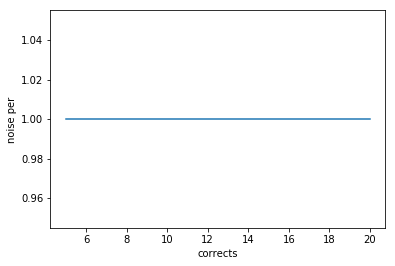

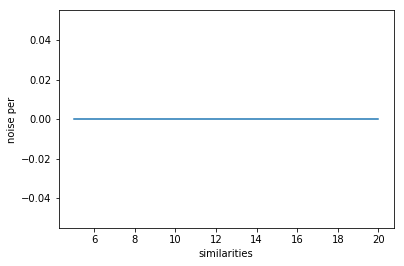

In [12]:
model = Hopfield()
model.memoralize([pattern1])
corrects, similarities = ex1(model, pattern1)

1種類のpatternを記憶させた場合, 5%~20%のノイズを付加しても元のpatternを完全に再現できている.

### 2. 同条件で画像の種類を6程度まで徐々に増やして想起性能を調べる実験

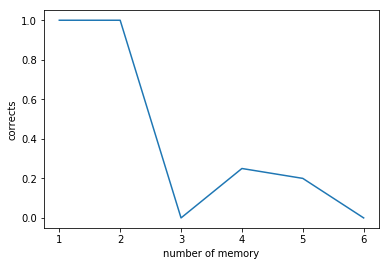

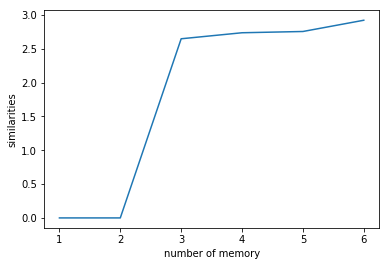

In [13]:
ex2()

平均正答率は特殊な挙動を示した.  
平均類似度は単調に増加している.

### 画像が2種類と4種類の場合について,ノイズを0%から100%まで徐々に増やして想起性能を調べる実験

記憶したパターン数 :  2


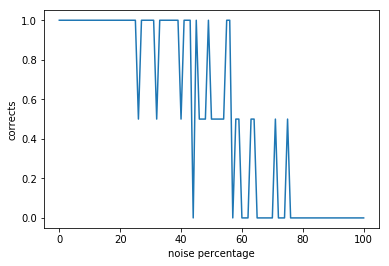

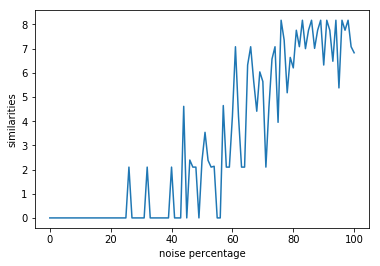

記憶したパターン数 :  4


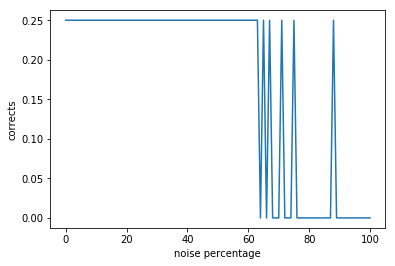

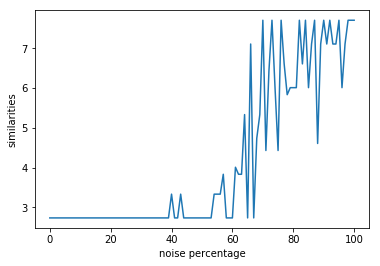

In [14]:
ex3()

どちらも50%を超えた付近で急激に平均正答率が下がり, 類似度は上がっている.  

### 予備実験

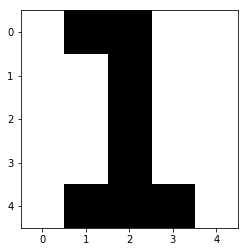

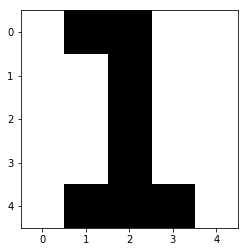

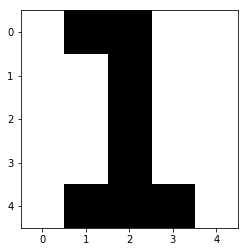

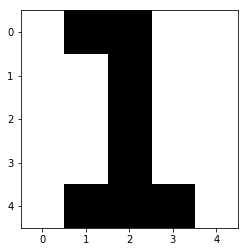

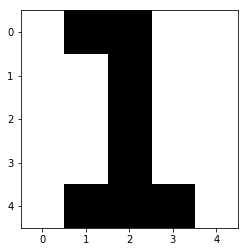

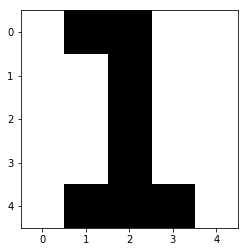

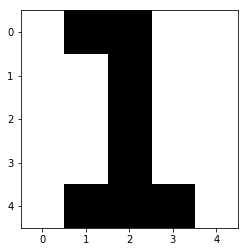

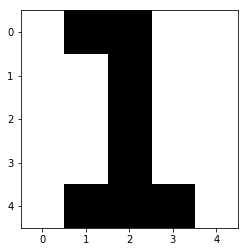

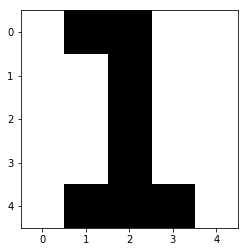

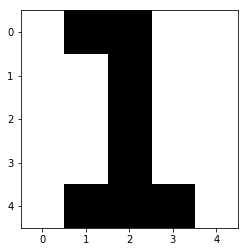

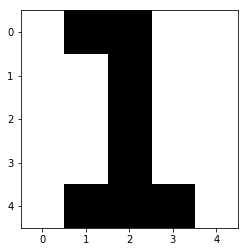

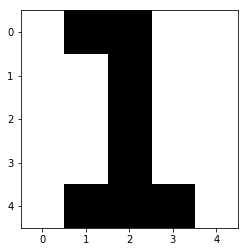

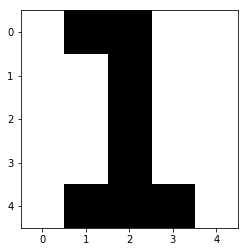

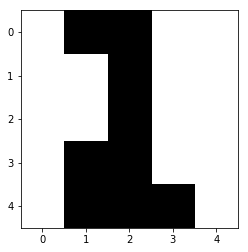

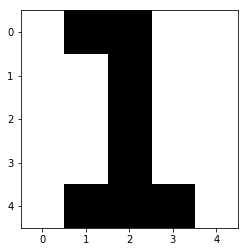

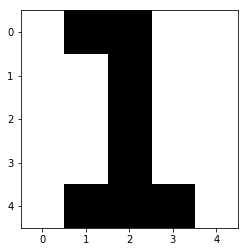

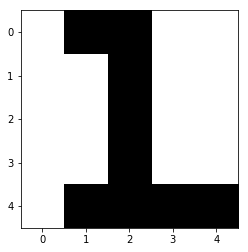

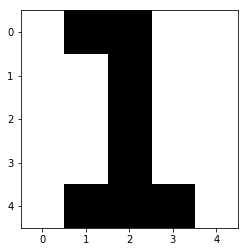

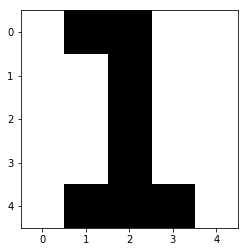

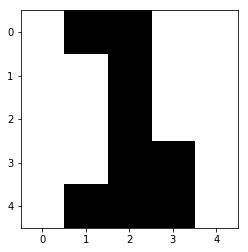

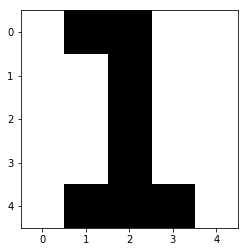

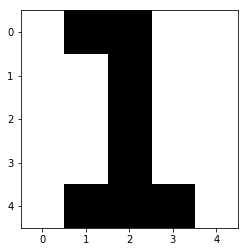

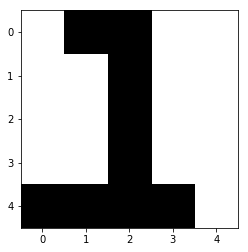

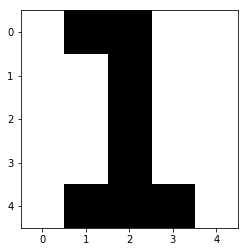

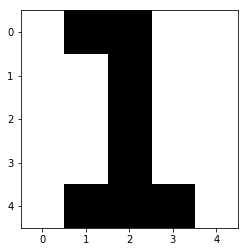

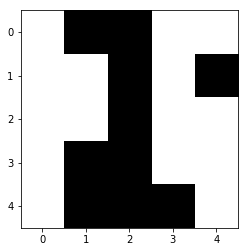

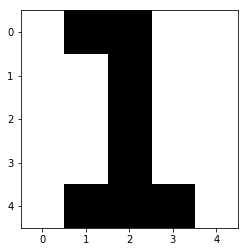

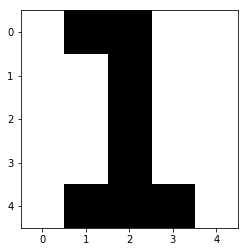

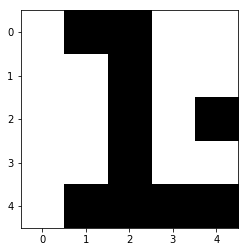

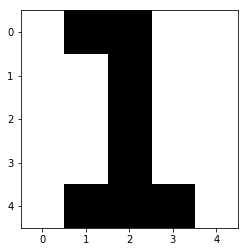

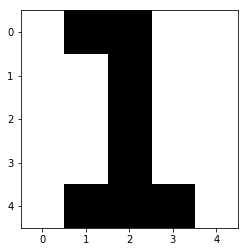

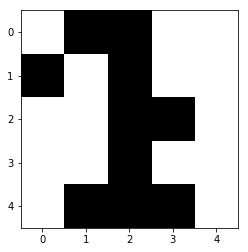

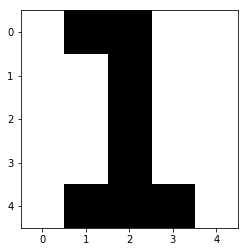

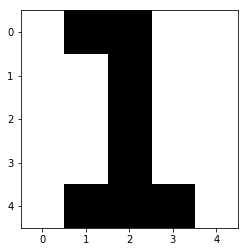

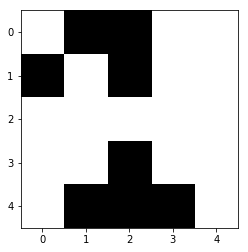

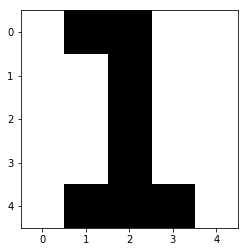

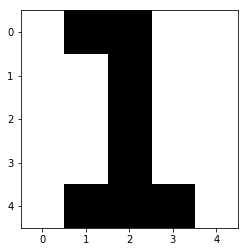

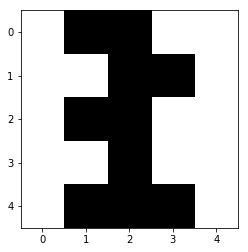

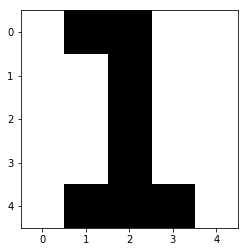

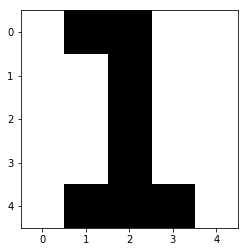

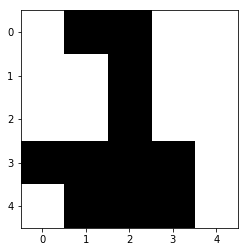

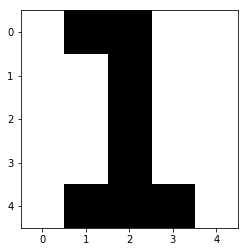

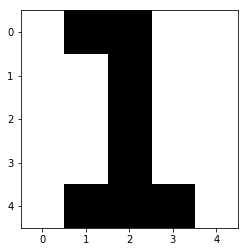

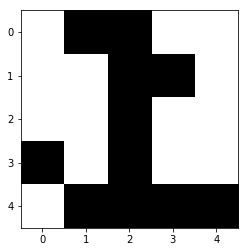

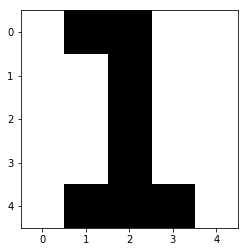

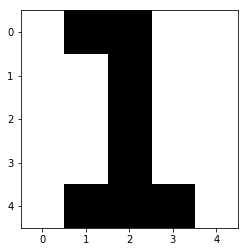

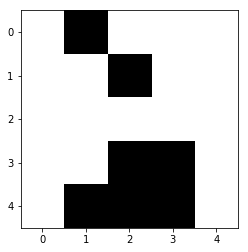

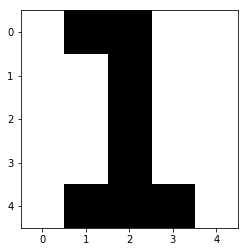

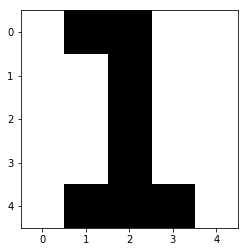

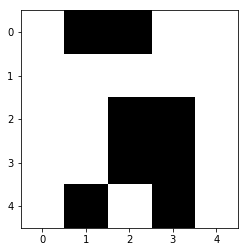

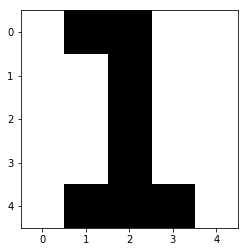

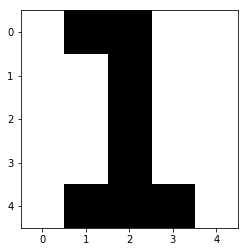

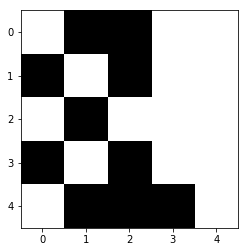

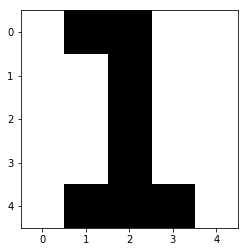

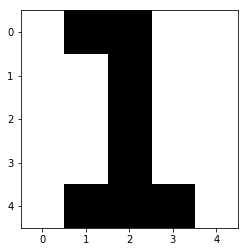

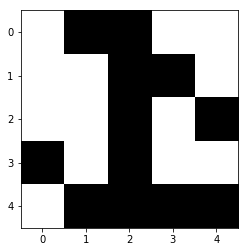

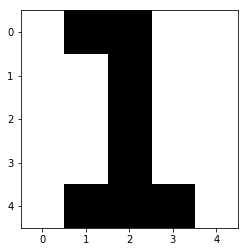

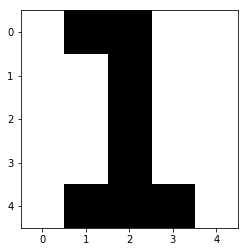

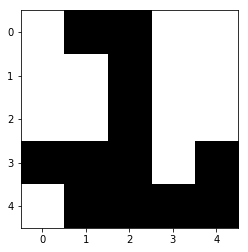

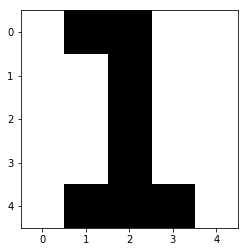

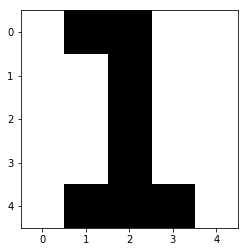

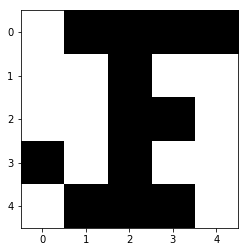

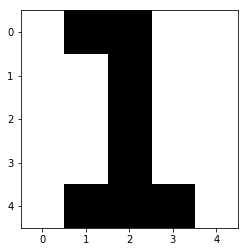

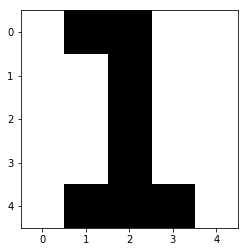

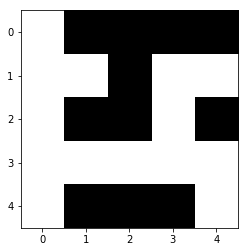

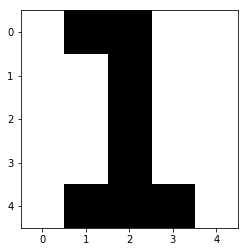

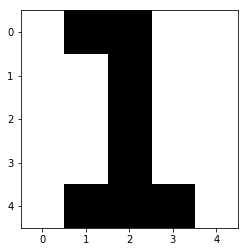

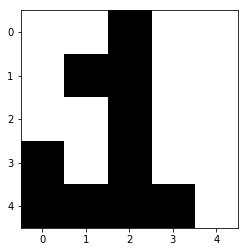

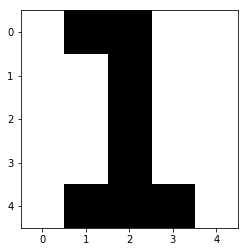

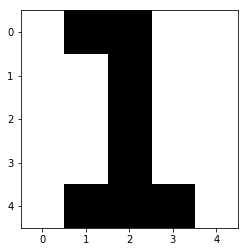

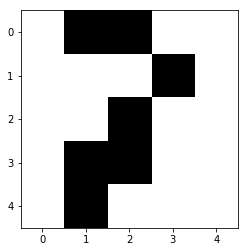

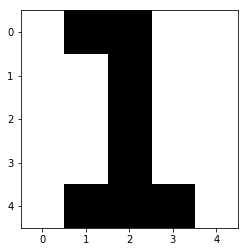

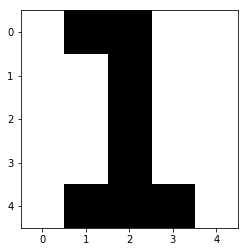

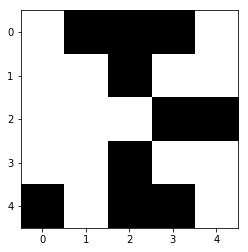

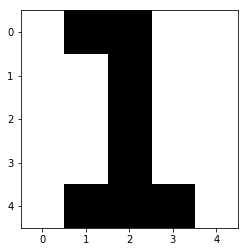

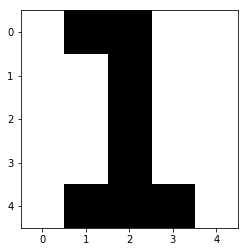

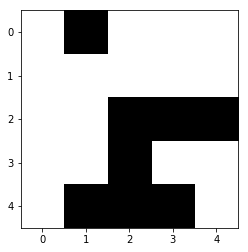

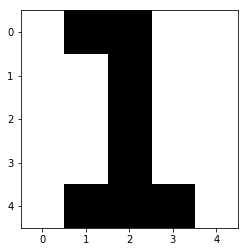

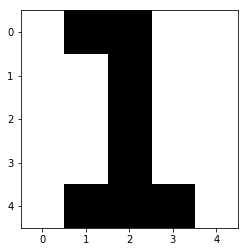

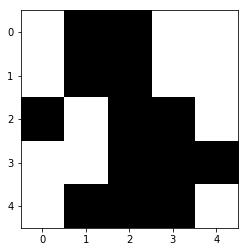

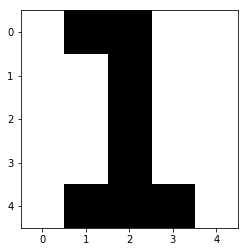

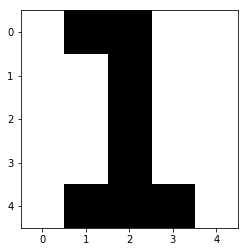

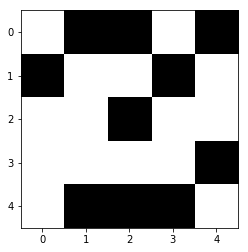

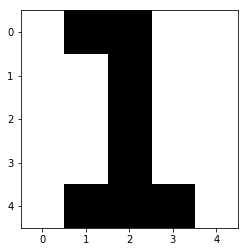

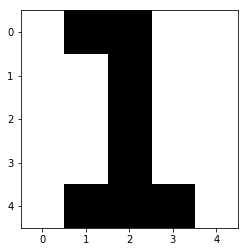

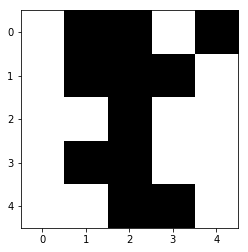

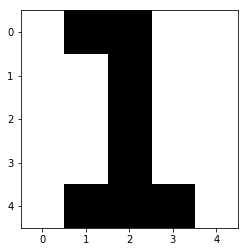

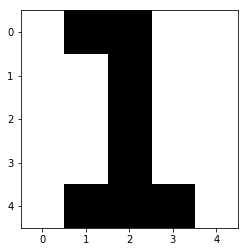

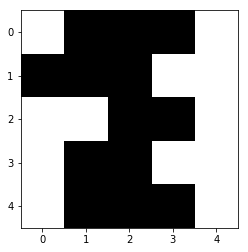

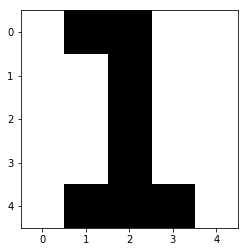

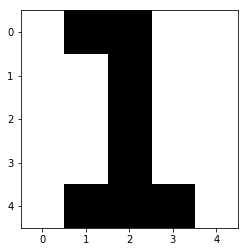

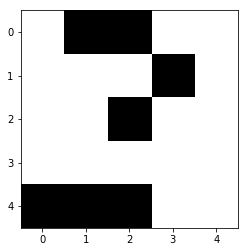

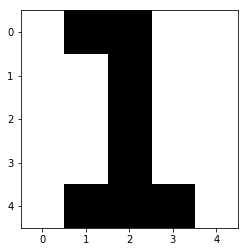

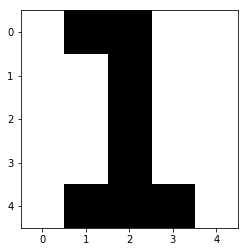

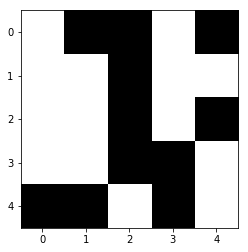

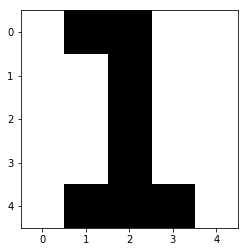

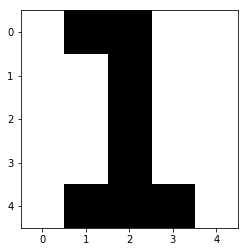

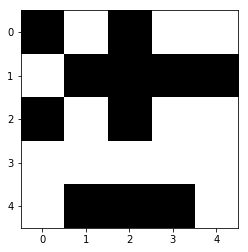

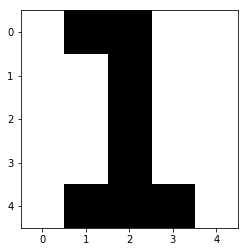

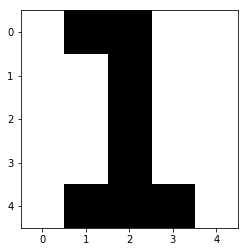

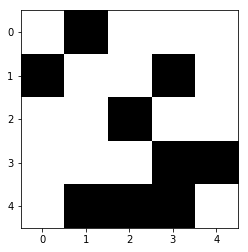

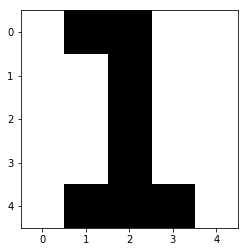

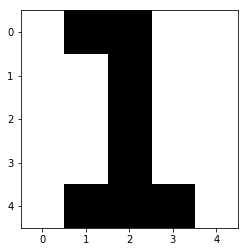

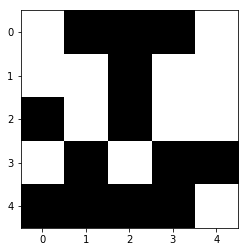

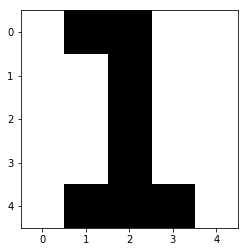

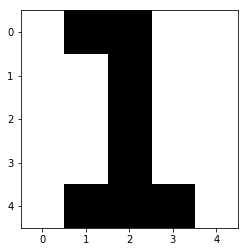

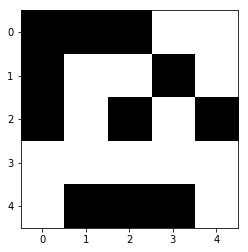

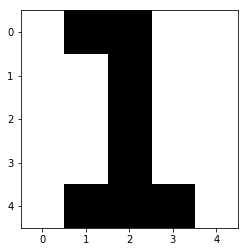

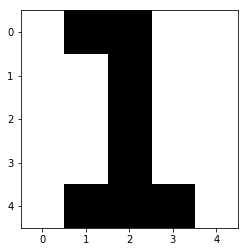

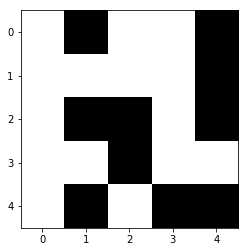

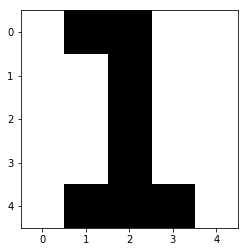

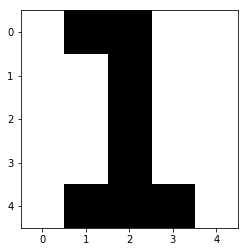

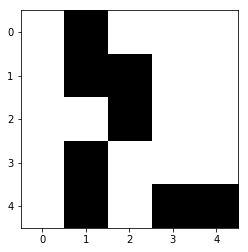

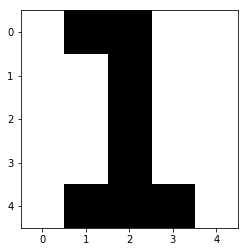

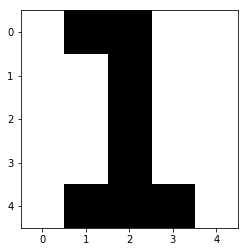

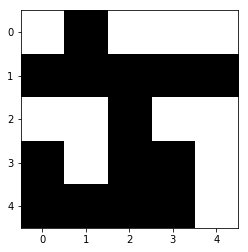

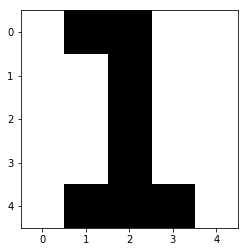

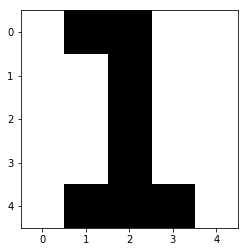

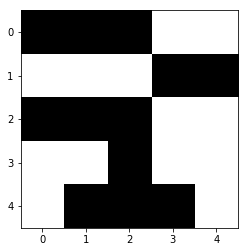

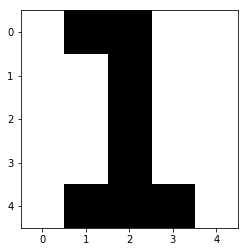

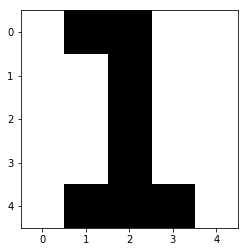

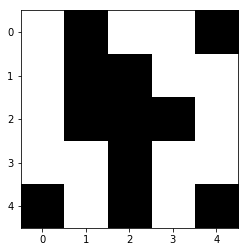

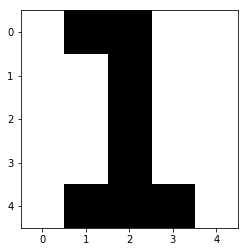

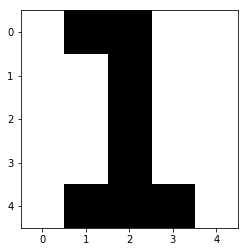

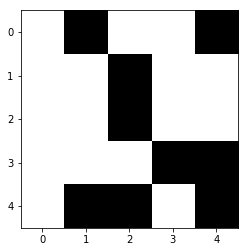

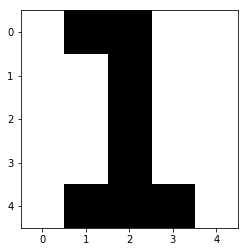

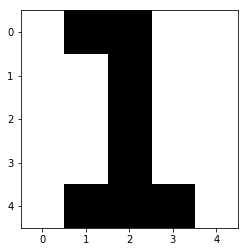

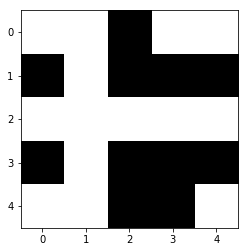

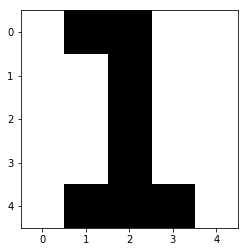

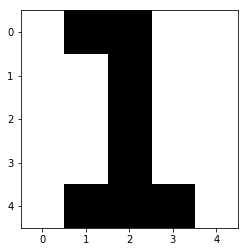

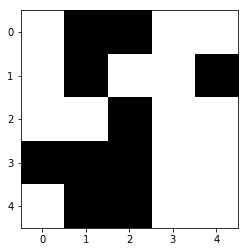

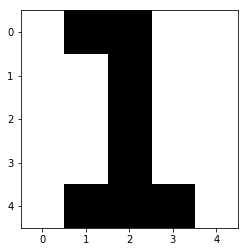

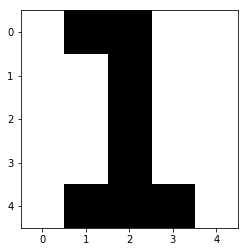

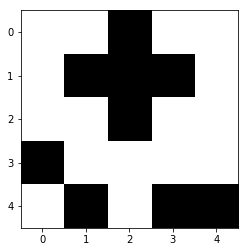

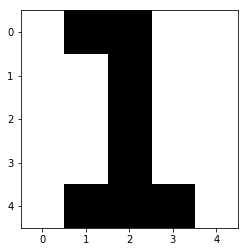

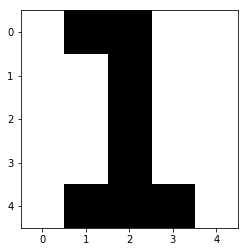

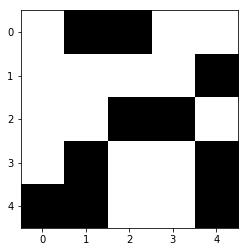

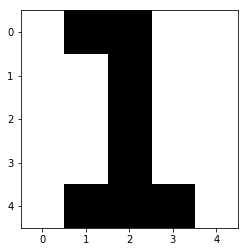

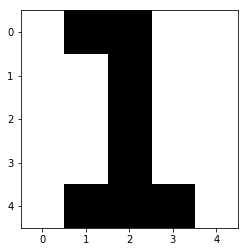

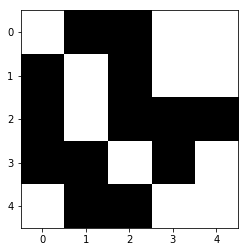

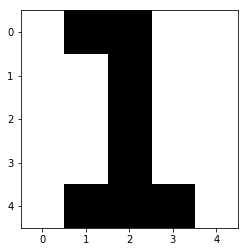

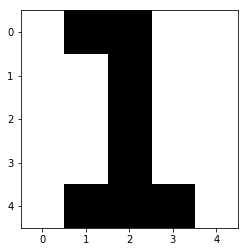

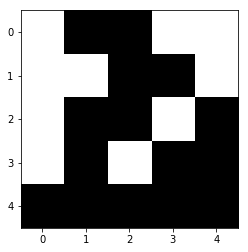

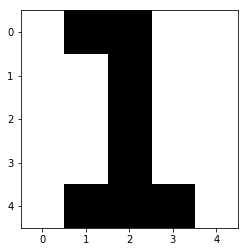

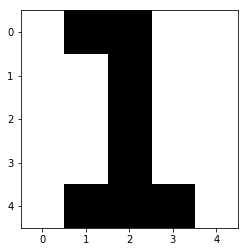

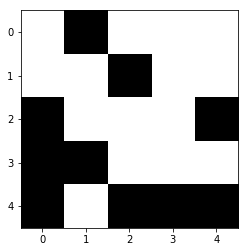

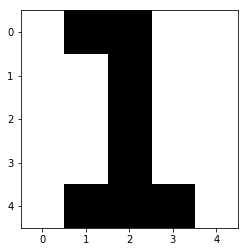

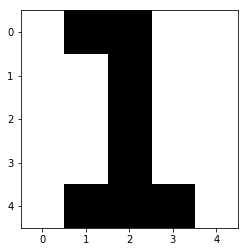

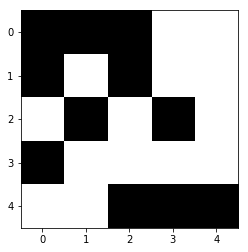

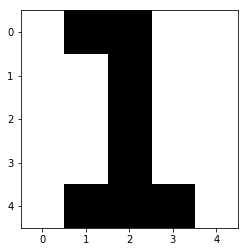

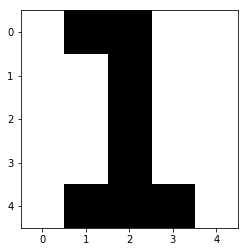

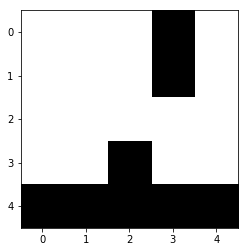

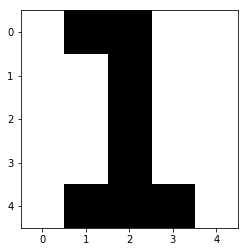

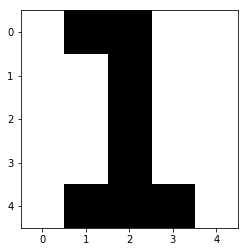

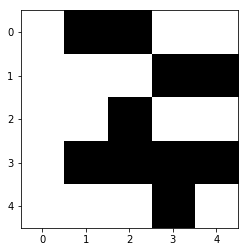

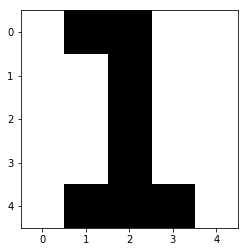

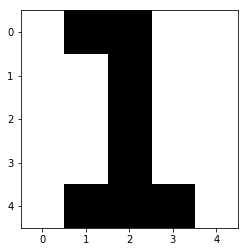

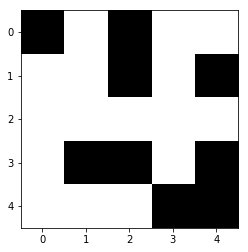

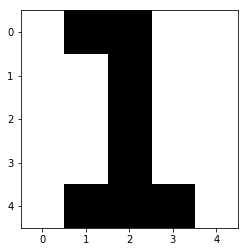

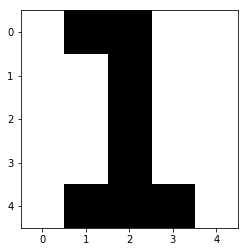

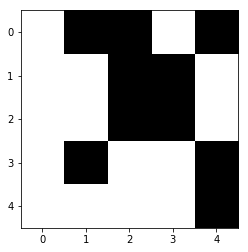

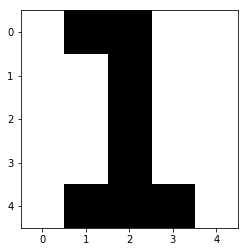

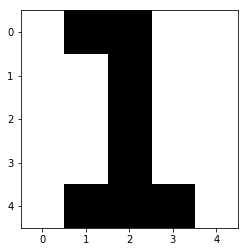

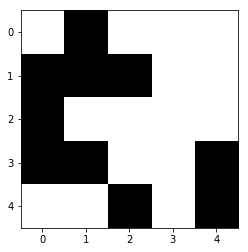

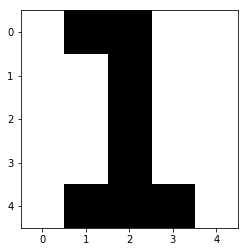

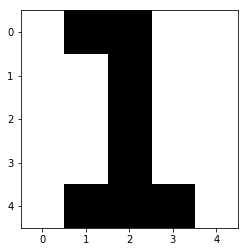

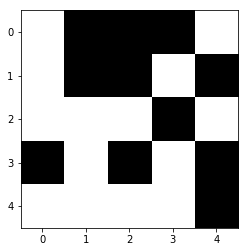

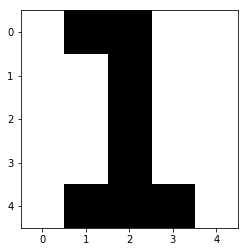

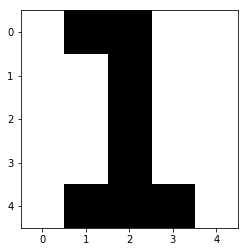

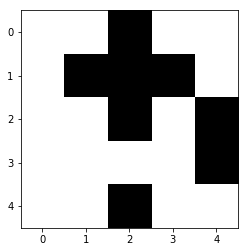

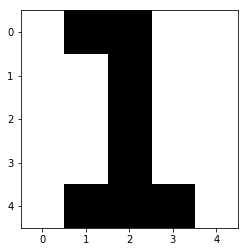

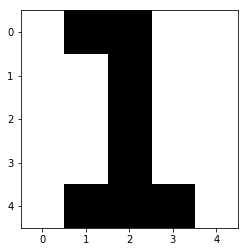

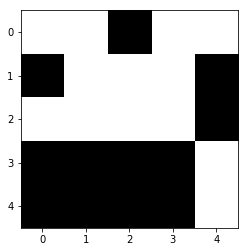

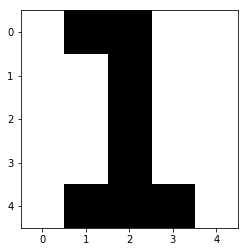

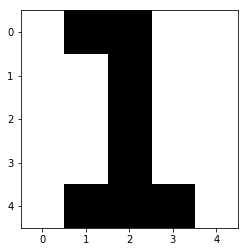

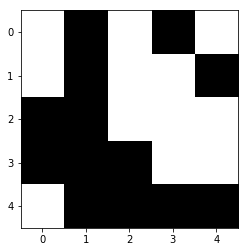

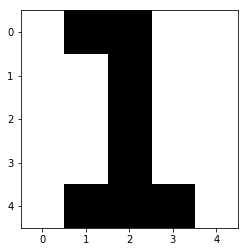

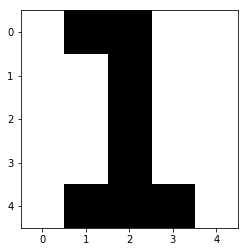

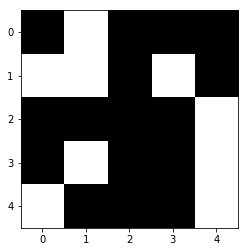

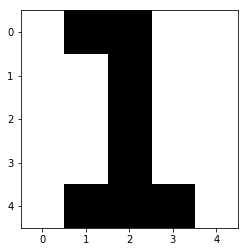

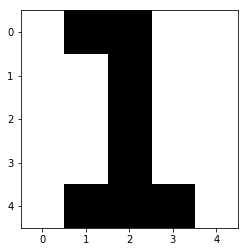

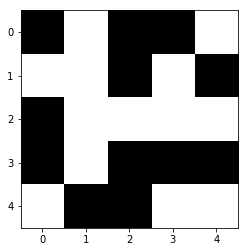

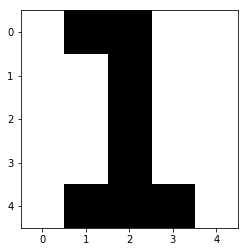

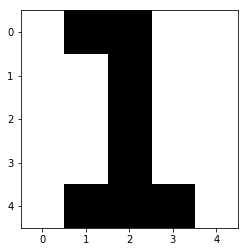

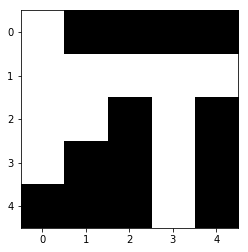

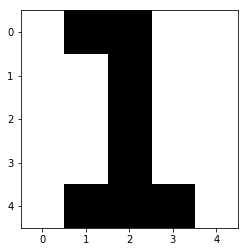

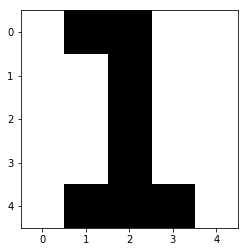

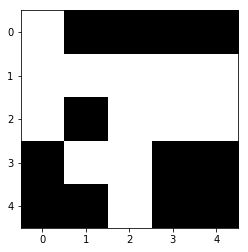

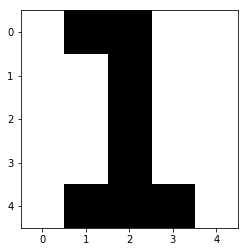

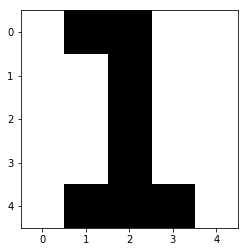

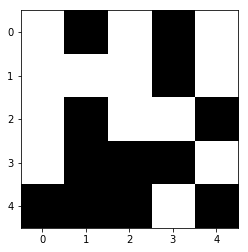

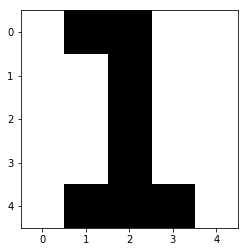

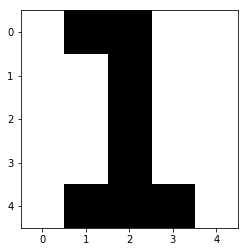

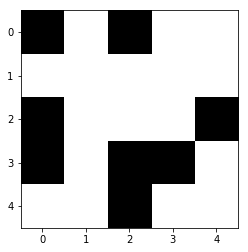

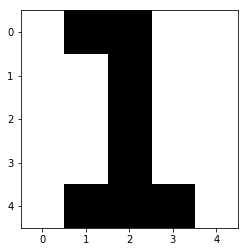

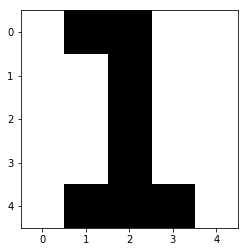

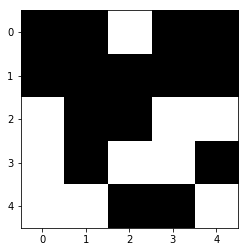

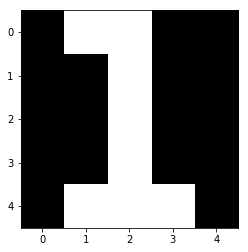

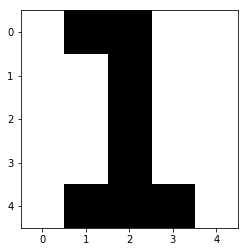

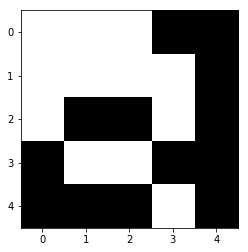

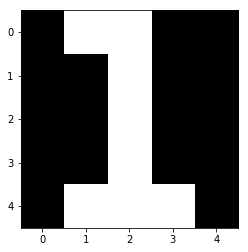

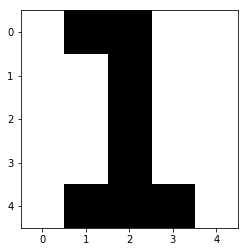

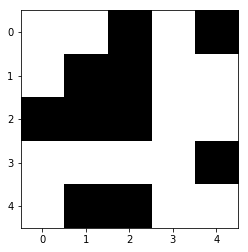

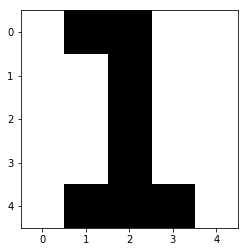

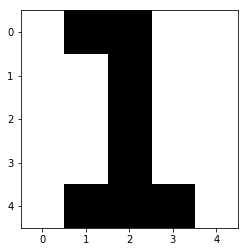

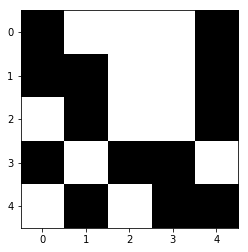

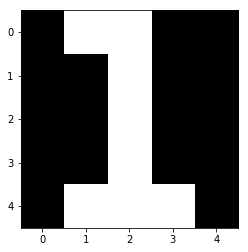

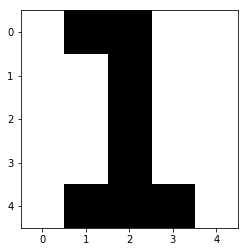

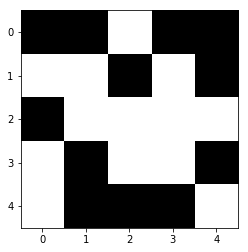

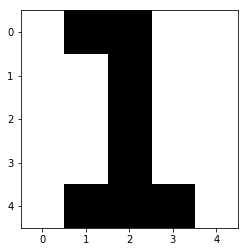

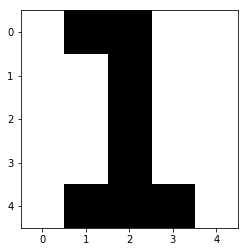

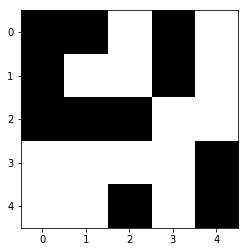

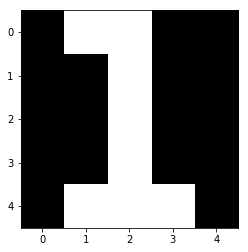

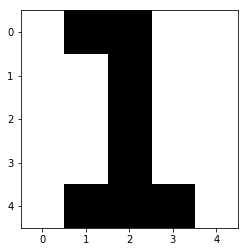

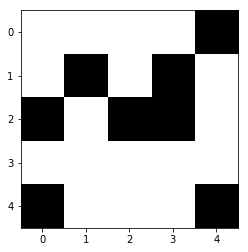

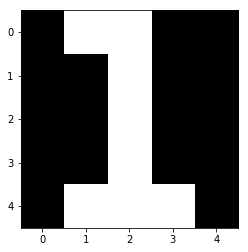

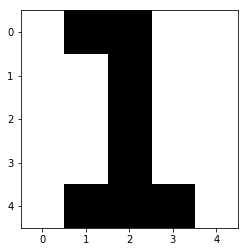

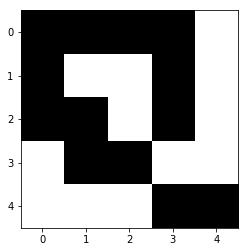

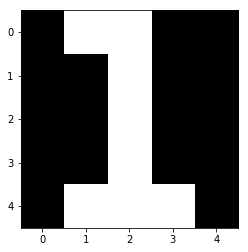

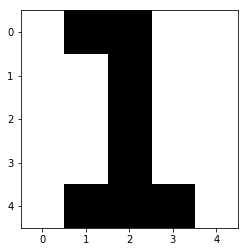

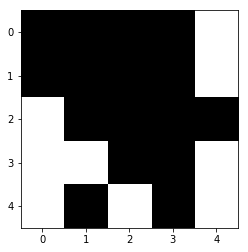

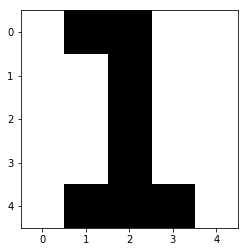

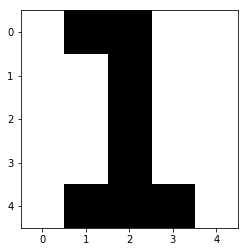

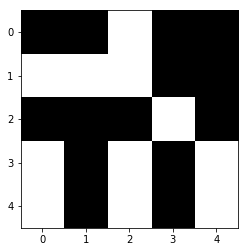

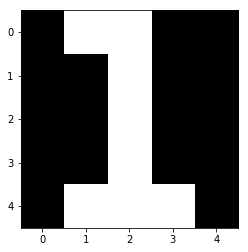

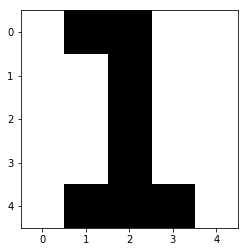

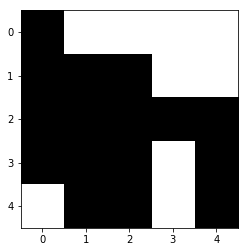

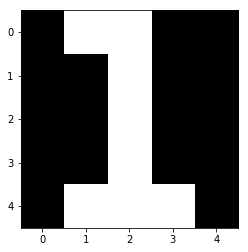

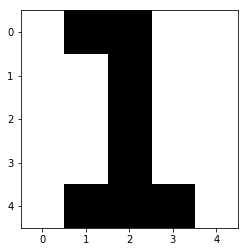

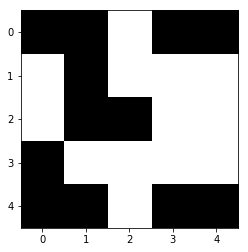

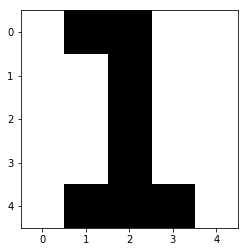

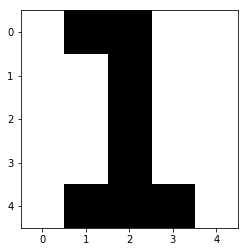

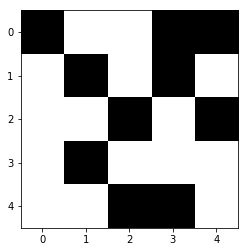

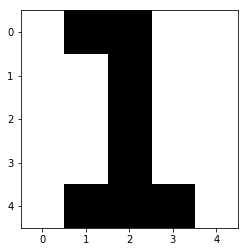

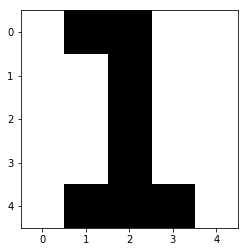

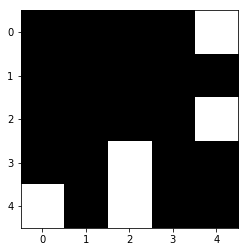

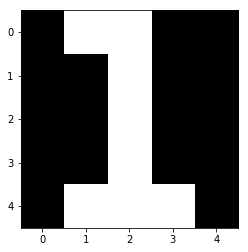

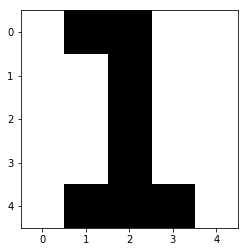

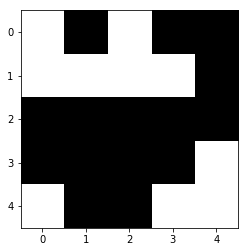

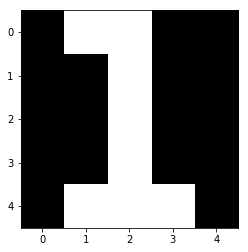

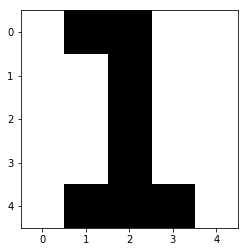

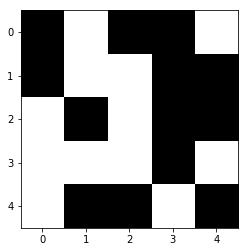

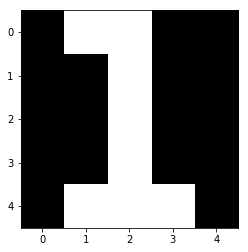

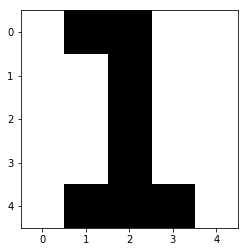

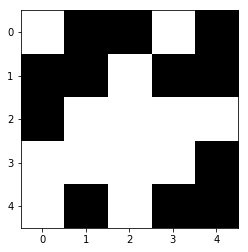

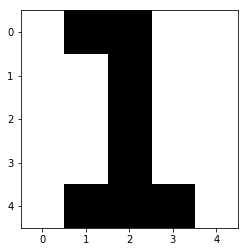

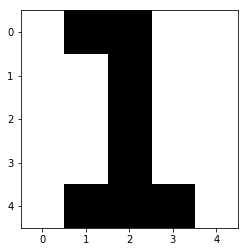

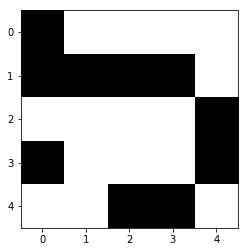

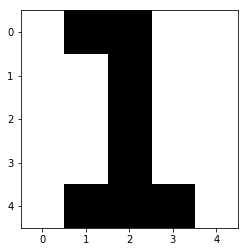

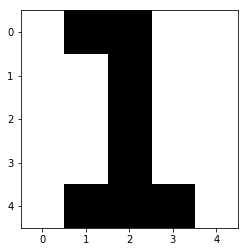

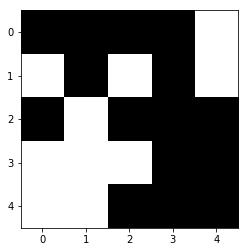

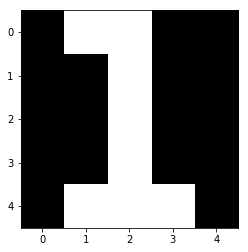

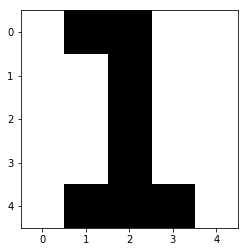

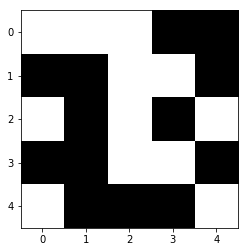

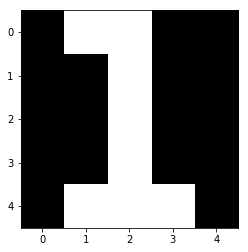

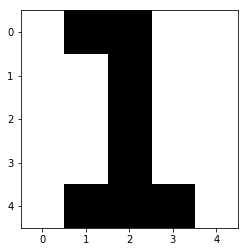

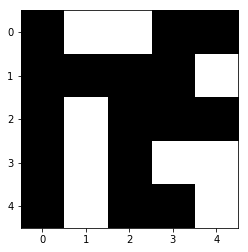

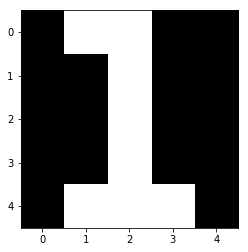

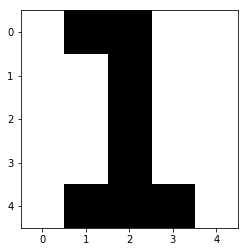

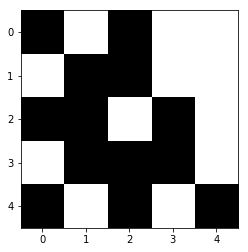

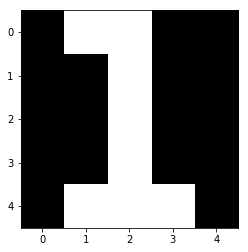

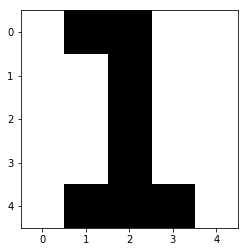

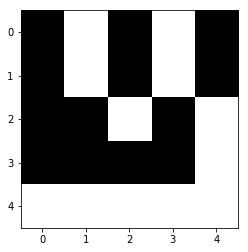

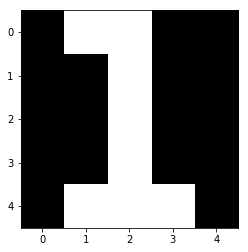

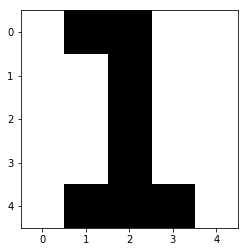

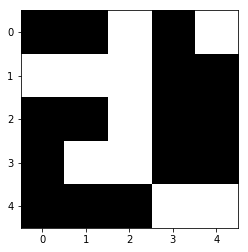

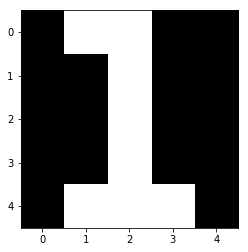

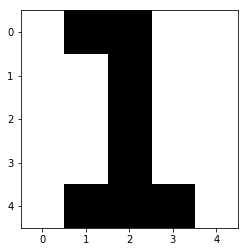

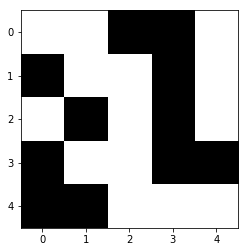

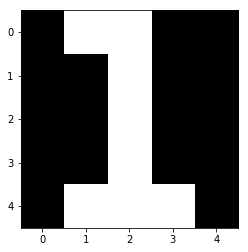

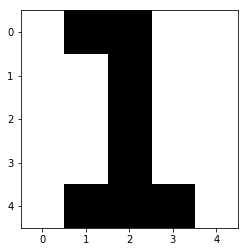

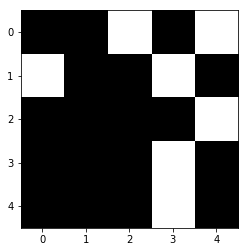

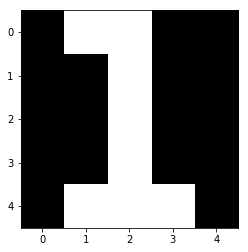

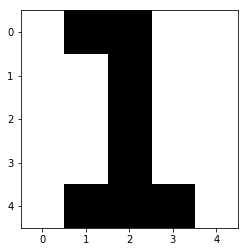

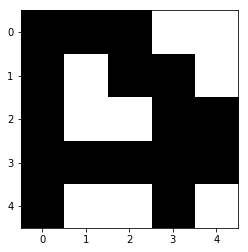

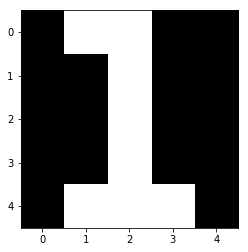

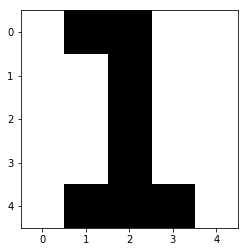

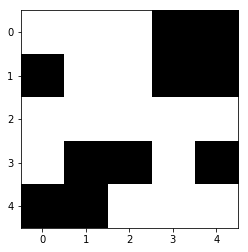

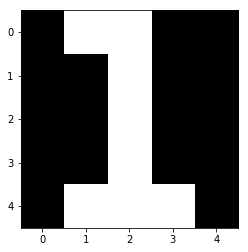

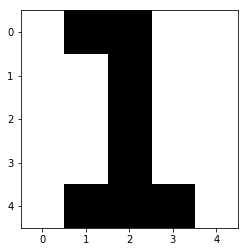

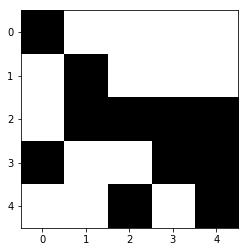

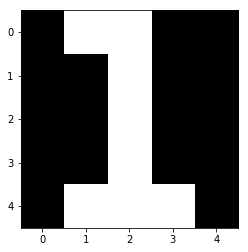

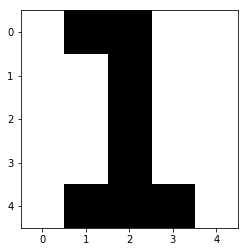

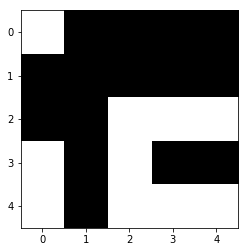

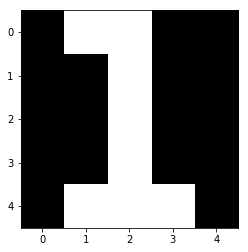

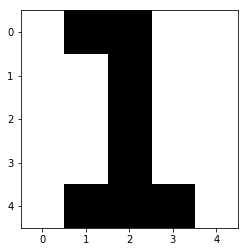

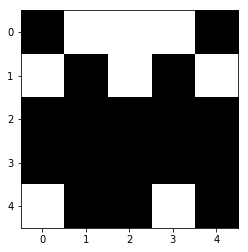

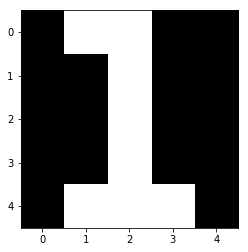

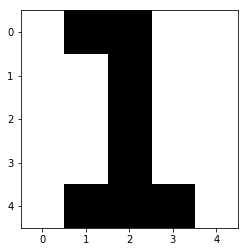

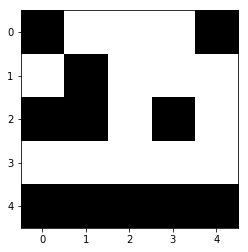

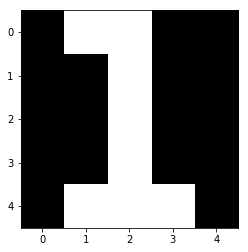

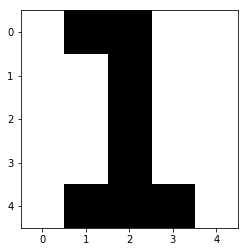

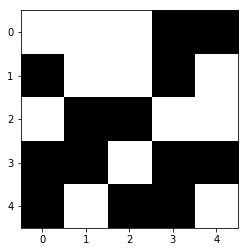

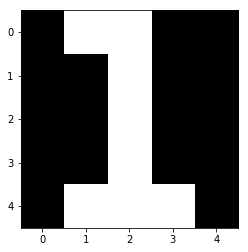

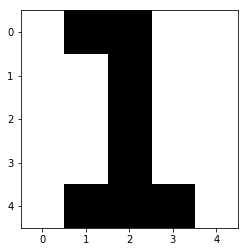

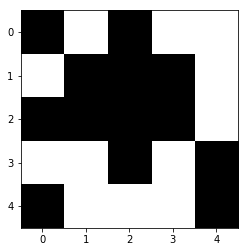

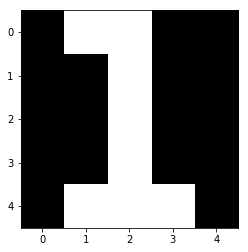

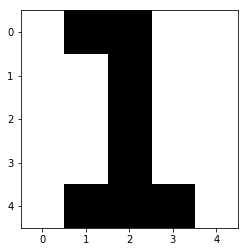

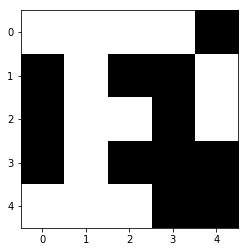

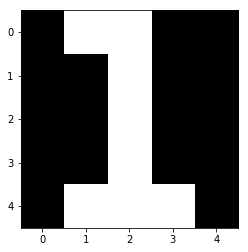

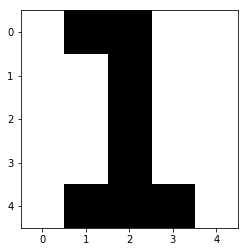

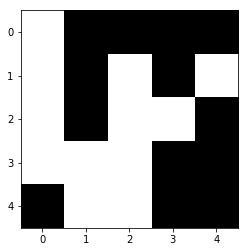

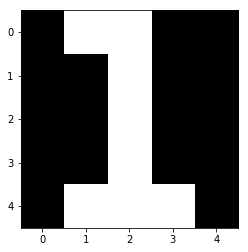

正答率の平均 0.7128712871287128
正解との類似度の全試行平均 2.4243296060985924


ValueError: x and y must have same first dimension, but have shapes (16,) and (101,)

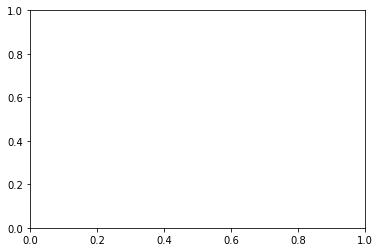

In [16]:
model = Hopfield()
model.memoralize([pattern1])
corrects, similarities = ex1(model, pattern1, noise_per_range=(0,101), debug=True)